In [15]:
# main_vac_osc script 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator, random_hermitian, SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

import sys
import os


In [16]:
backend_name = "aer" #manila, aer

In [17]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [18]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.25.0'

In [19]:
# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [36]:

def initialize_parameters():
    N_sites = 4  # Number of qubits
    delta_m_squared = np.pi
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    shots = 1000
    # backend = AerSimulator(method='automatic')
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        backend = AerSimulator(method='automatic')
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 5  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    Δx = 1E-3 # length of the box of interacting neutrinos at a site in cm #variable
    L = 1 # cm # not being used in this test but defined to keep the evolve function arguments consistent.
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = np.pi / 4  # mixing_angle in radians
    # Initialize an array of zeros for all N_sites particles
    mu = np.zeros(N_sites)

    # Create an array of dimension N and fill it with the value 1/(sqrt(2) * G_F). This is the number of neutrinos.
    N = mu * np.full(N_sites, (Δx**3) / (np.sqrt(2) * G_F * N_sites))
    # Create a B vector which would be same for all N particles
    B = np.array([np.sin(2 * theta_nu), 0, -np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)

    # Generate x, y, and z arrays
    x = np.random.rand(N_sites)
    y = np.random.rand(N_sites)
    z = np.zeros(N_sites)

    # Generate an Nx3 array for p with ones as values
    p = np.ones((N_sites, 3))

    # All of the sites are neutrinos, energy_sign array
    energy_sign = np.ones(N_sites)
    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file


    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times



In [37]:
# def simulate(times, omega, N_sites, H, backend, shots, τ, tolerance):
def simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance):
    sigma_z_values = []
    expected_sz_array = []

    for t in times:
        expected_sz = [-1 * np.cos(omega_i * t) for omega_i in omega]
        expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)
        
        # qc = evolve_and_measure_circuit(t, pauli_terms, N_sites)
        # job = backend.run(qc, shots=shots)
        # result = job.result()
        # counts = result.get_counts(qc)

        qc = evolve_and_measure_circuit(t, pauli_terms, N_sites)
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuit = pm.run(qc)

        # Get counts from the result
        sampler = Sampler(mode=backend)
        job = sampler.run([isa_circuit],shots=shots)
        result = job.result()

        pub_result = result[0]
        counts = pub_result.data.c.get_counts()
        
        # Calculate expectation value of sigma_z for the first qubit
        sigma_z = 0
        for outcome, count in counts.items():
            if outcome[0] == '0':
                sigma_z += count / shots
            else:
                sigma_z -= count / shots
        sigma_z_values.append(sigma_z)
 
    
    # assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

    return sigma_z_values, expected_sz_array, isa_circuit

In [38]:

def plot_results(times, sigma_z_values, expected_sz_array, N_sites):
    plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
    plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('$\sigma_z$')
    plt.title(f'$\sigma_z$ vs Time ({N_sites} Qubits, $H_{{vac}}$ Term)')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

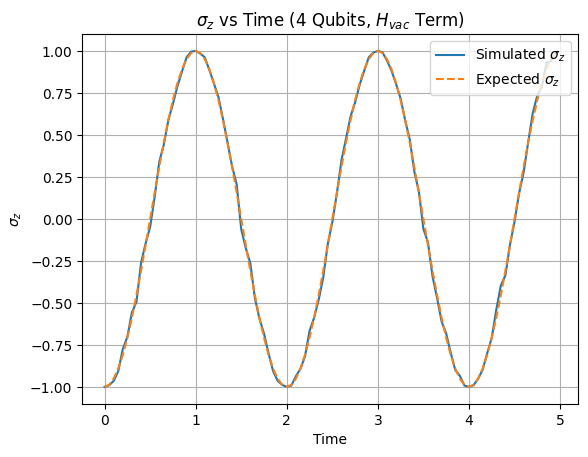

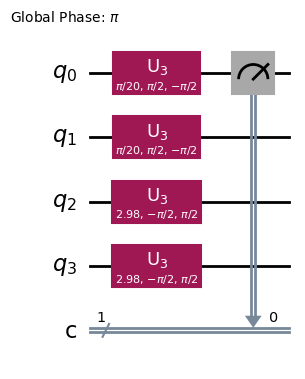

In [39]:
    N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
    pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
    sigma_z_values, expected_sz_array, circuit = simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, expected_sz_array, N_sites)
    circuit.draw(output="mpl")

In [27]:

def main():
    N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, shape_name , shots, backend, tolerance, τ, times= initialize_parameters()
    pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
    sigma_z_values, expected_sz_array, circuit = simulate(times, omega, N_sites, pauli_terms, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, expected_sz_array, N_sites)
    circuit.draw(output="mpl")

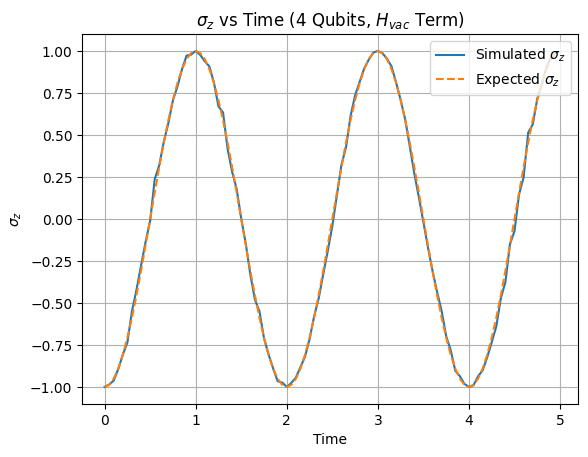

In [28]:
if __name__ == "__main__":
    main()
